In [5]:
import pulp
import pandas
import numpy as np
np.seed=1

def create_sim(t0,amplitud,desfase,beta,sigma):
    Tiempos=range(12)
    dat=[t0+amplitud*np.sin((t-desfase)/12*2*np.pi) for t in Tiempos]
    out=[dat[0]+sigma*np.random.normal(0,1)]
    for t in range(1,12):
        out.append(dat[(t+1)%12]-beta*(out[-1]-dat[t])+sigma*np.random.normal(0,1))
    return out


In [6]:
Insumos={"Damasco","Durazno","Azucar"}
Mermeladas={"tipo1","tipo2","tipo3"}
Tiempos=range(0,12)         

Disponibilidad={"Damasco":create_sim(80,40,0,0.4,3),
                "Durazno":create_sim(100,20,0,0.4,3),
                "Azucar": [300 for t in Tiempos]}
Costo={"Damasco":create_sim(1000,400,0,0.4,60),
       "Durazno":create_sim(1200,300,0,0.4,50),
       "Azucar":[400 for t in Tiempos]}
Req={"tipo1":{"Damasco":0.7,"Durazno":0,"Azucar":0.3},
                "tipo2":{"Damasco":0.1,"Durazno":0.5,"Azucar":0.4},
                "tipo3":{"Damasco":0.5,"Durazno":0.5,"Azucar":0}}
Precio={"tipo1":create_sim(2000,200,0,0.4,30),
        "tipo2":create_sim(2200,250,0,0.4,30),
        "tipo3":create_sim(3000,300,0,0.4,30)}
Demanda={"tipo1":create_sim(100,20,0,0.4,30),
         "tipo2":create_sim(150,50,0,0.4,30),
         "tipo3":create_sim(200,20,0,0.4,30)}
Perdidas=0.05

Costo_almacen=200
Bodega_limite=100


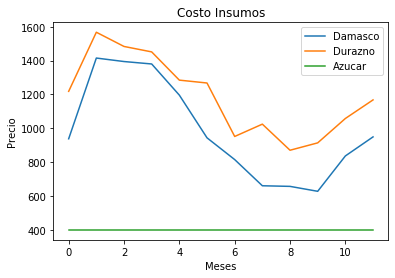

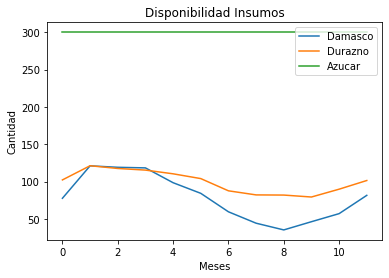

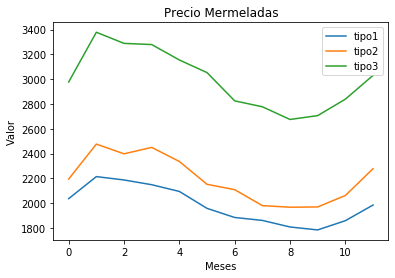

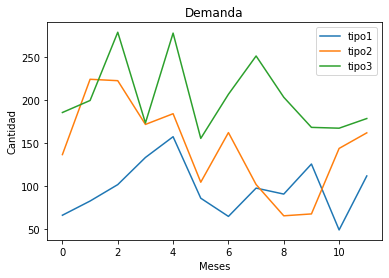

In [7]:
import matplotlib.pyplot as plt

for n,c in Costo.items():
    plt.plot(c, label=n)
    
plt.title('Costo Insumos')
plt.xlabel('Meses')
plt.ylabel('Precio')

plt.legend(loc="upper right")

plt.show()

for n,d in Disponibilidad.items():
    plt.plot(d, label=n)
    
plt.title('Disponibilidad Insumos')
plt.xlabel('Meses')
plt.ylabel('Cantidad')

plt.legend(loc="upper right")
plt.show()

for n,p in Precio.items():
    plt.plot(p, label=n)
    
plt.title('Precio Mermeladas')
plt.xlabel('Meses')
plt.ylabel('Valor')

plt.legend(loc="upper right")

plt.show()



for n,d in Demanda.items():
    plt.plot(d, label=n)
    
plt.title('Demanda')
plt.xlabel('Meses')
plt.ylabel('Cantidad')

plt.legend(loc="upper right")


plt.show()


In [8]:
prob = pulp.LpProblem("MermeladasDinamico", pulp.LpMaximize)

x = pulp.LpVariable.dicts("MermeladaProducida", ((m,t) for m in Mermeladas for t in Tiempos), lowBound=0, cat='Continuous')
v = pulp.LpVariable.dicts("MermeladaVendida", ((m,t) for m in Mermeladas for t in Tiempos), lowBound=0, cat='Continuous')
a = pulp.LpVariable.dicts("Insumos", ((i,t) for i in Insumos for t in Tiempos), lowBound=0, cat='Continuous')
b = pulp.LpVariable.dicts("Bodega", ((m,t) for m in Mermeladas for t in Tiempos), lowBound=0, cat='Continuous')

In [9]:
prob += pulp.lpSum([v[(m,t)]*Precio[m][t] for m in Mermeladas for t in Tiempos]) \
        - pulp.lpSum([a[(i,t)]*Costo[i][t] for i in Insumos for t in Tiempos])  \
        - pulp.lpSum([b[(m,t)]*Costo_almacen for m in Mermeladas for t in Tiempos]) 


In [10]:
for t in Tiempos:
    #Calculo de insumos por tiempo
    for i in Insumos:
        prob += pulp.lpSum([x[(m,t)]*Req[m][i] for m in Mermeladas])== a[(i,t)]
    #Disponibilidad de insumos por tiempo
    for i in Insumos:
        prob += a[(i,t)]<= Disponibilidad[i][t]
        
    #Satisfaccion de demanda para calculo de utilidades por tiempo    
    for m in Mermeladas:
        prob += v[(m,t)]<= Demanda[m][t]

    #Limite de la Bodega
    prob += pulp.lpSum([b[(m,t)] for m in Mermeladas])<= Bodega_limite
    
#init de bodega    
for m in Mermeladas:
    prob += b[(m,0)]==0
    
for t in range(0,11):
    #Calculo de bodegaje
    for m in Mermeladas:
        prob += b[(m,t)]*(1-0.05)+x[(m,t)]==v[(m,t)]+b[(m,t+1)]
for m in Mermeladas: 
    prob += b[(m,0)]*(1-0.05)+x[(m,1)]==v[(m,1)]


In [11]:
# Choose solver, and set it to problem, and build the Gurobi model
solver = pulp.GUROBI()
prob.setSolver(solver)
prob.solver.buildSolverModel(prob)

# Solve model
prob.solve()


Using license file /home/maxi/anaconda3/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 159 rows, 144 columns and 372 nonzeros
Model fingerprint: 0x245c6bfe
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+02, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 3e+02]
Presolve removed 90 rows and 22 columns
Presolve time: 0.01s
Presolved: 69 rows, 122 columns, 252 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3205822e+07   1.347600e+03   0.000000e+00      0s
      58    5.0278437e+06   0.000000e+00   0.000000e+00      0s

Solved in 58 iterations and 0.01 seconds
Optimal objective  5.027843722e+06
Gurobi status= 2


1

In [12]:
prob

MermeladasDinamico:
MAXIMIZE
-200*Bodega_('tipo1',_0) + -200*Bodega_('tipo1',_1) + -200*Bodega_('tipo1',_10) + -200*Bodega_('tipo1',_11) + -200*Bodega_('tipo1',_2) + -200*Bodega_('tipo1',_3) + -200*Bodega_('tipo1',_4) + -200*Bodega_('tipo1',_5) + -200*Bodega_('tipo1',_6) + -200*Bodega_('tipo1',_7) + -200*Bodega_('tipo1',_8) + -200*Bodega_('tipo1',_9) + -200*Bodega_('tipo2',_0) + -200*Bodega_('tipo2',_1) + -200*Bodega_('tipo2',_10) + -200*Bodega_('tipo2',_11) + -200*Bodega_('tipo2',_2) + -200*Bodega_('tipo2',_3) + -200*Bodega_('tipo2',_4) + -200*Bodega_('tipo2',_5) + -200*Bodega_('tipo2',_6) + -200*Bodega_('tipo2',_7) + -200*Bodega_('tipo2',_8) + -200*Bodega_('tipo2',_9) + -200*Bodega_('tipo3',_0) + -200*Bodega_('tipo3',_1) + -200*Bodega_('tipo3',_10) + -200*Bodega_('tipo3',_11) + -200*Bodega_('tipo3',_2) + -200*Bodega_('tipo3',_3) + -200*Bodega_('tipo3',_4) + -200*Bodega_('tipo3',_5) + -200*Bodega_('tipo3',_6) + -200*Bodega_('tipo3',_7) + -200*Bodega_('tipo3',_8) + -200*Bodega_('tipo3'

In [13]:
variables={"MermeladaProducida":["tipo1","tipo2","tipo3"],"MermeladaVendida":["tipo1","tipo2","tipo3"], "Bodega":["tipo1","tipo2","tipo3"], "Insumos":["Damasco","Durazno","Azucar"]}

list(variables.keys())

['MermeladaProducida', 'MermeladaVendida', 'Bodega', 'Insumos']

In [14]:
out={i:{} for n in list(variables.keys())}
tipos=["tipo1","tipo2","tipo3"]

varnombre1=['MermeladaProducida', 'MermeladaVendida', 'Bodega']
for nombre in varnombre1:
    out[nombre]={}
    for tipo in tipos:
        out[nombre][tipo]=[0 for t in Tiempos]
        for t in Tiempos:
            if nombre=="MermeladaProducida":
                out[nombre][tipo][t]=x[(tipo,t)].varValue
            if nombre=="MermeladaVendida":
                out[nombre][tipo][t]=v[(tipo,t)].varValue
            if nombre=="Bodega":
                out[nombre][tipo][t]=b[(tipo,t)].varValue
nombre="Insumos"
tipos=["Damasco","Durazno","Azucar"]
out[nombre]={}
for tipo in tipos:
    out[nombre][tipo]=[0 for t in Tiempos]
    out[nombre][tipo][t]=a[(tipo,t)].varValue

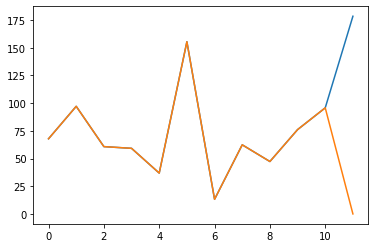

In [15]:
plt.plot(out["MermeladaVendida"]["tipo3"])
plt.plot(out["MermeladaProducida"]["tipo3"])



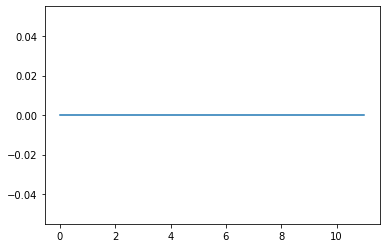

In [18]:
plt.plot(out["Bodega"]["tipo1"])